In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
HOTSPOT_CSV = '/content/customer.csv'

# Reading the CSV to check the header and first data points
with open(HOTSPOT_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

date,customer

First data point looks like this:

2018-01-01,44

Second data point looks like this:

2018-01-02,30



In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
def parse_data_from_file(filename):
    times = []
    usage = []
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            usage.append(float(row[1]))
        times = [x for x in range(len(usage))]
    return times, usage

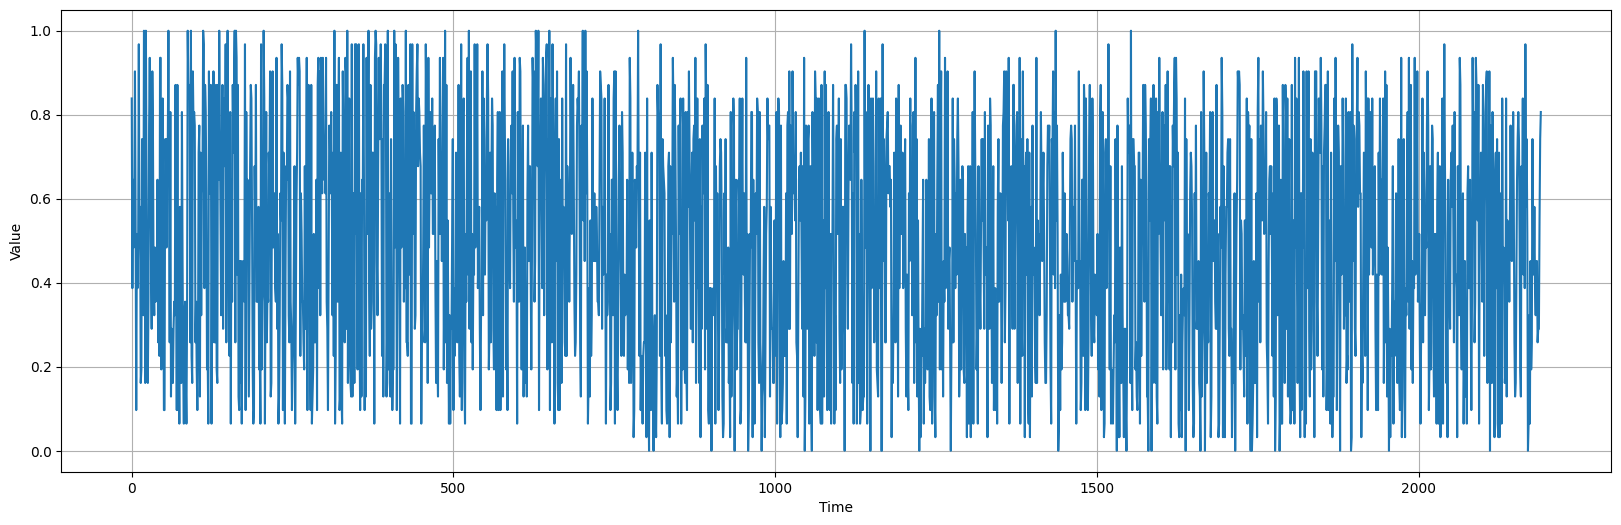

In [ ]:
@dataclass
class G:
    TEMPERATURES_CSV = '/content/customer.csv'
    times, usage = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(usage)
    SPLIT_TIME = int(len(SERIES) * 0.9)
    WINDOW_SIZE = 32
    BATCH_SIZE = 64
    SHUFFLE_BUFFER_SIZE = 100

# Normalize the data
scaler = MinMaxScaler()
G.SERIES = scaler.fit_transform(G.SERIES.reshape(-1, 1)).squeeze()

plt.figure(figsize=(20, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]
    return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [ ]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

In [ ]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="causal", activation="relu"),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x * 400)
    ])
    return model

# Test your uncompiled model
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(train_set)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

31/31 [==============================] - 3s 47ms/step
Your current architecture is compatible with the windowed dataset! :)


In [ ]:
def adjust_learning_rate(dataset):
    model = create_uncompiled_model()
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    return history

# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
31/31 [==============================] - 7s 81ms/step - loss: 0.4183 - mae: 0.7606 - lr: 1.0000e-04
Epoch 2/100
31/31 [==============================] - 2s 56ms/step - loss: 0.1135 - mae: 0.3873 - lr: 1.1220e-04
Epoch 3/100
31/31 [==============================] - 2s 57ms/step - loss: 0.0817 - mae: 0.3259 - lr: 1.2589e-04
Epoch 4/100
31/31 [==============================] - 2s 55ms/step - loss: 0.0567 - mae: 0.2821 - lr: 1.4125e-04
Epoch 5/100
31/31 [==============================] - 2s 71ms/step - loss: 0.0534 - mae: 0.2747 - lr: 1.5849e-04
Epoch 6/100
31/31 [==============================] - 3s 87ms/step - loss: 0.0695 - mae: 0.3086 - lr: 1.7783e-04
Epoch 7/100
31/31 [==============================] - 2s 56ms/step - loss: 0.0634 - mae: 0.2930 - lr: 1.9953e-04
Epoch 8/100
31/31 [==============================] - 2s 58ms/step - loss: 0.0473 - mae: 0.2624 - lr: 2.2387e-04
Epoch 9/100
31/31 [==============================] - 2s 57ms/step - loss: 0.0536 - mae: 0.2728 - lr: 2.5

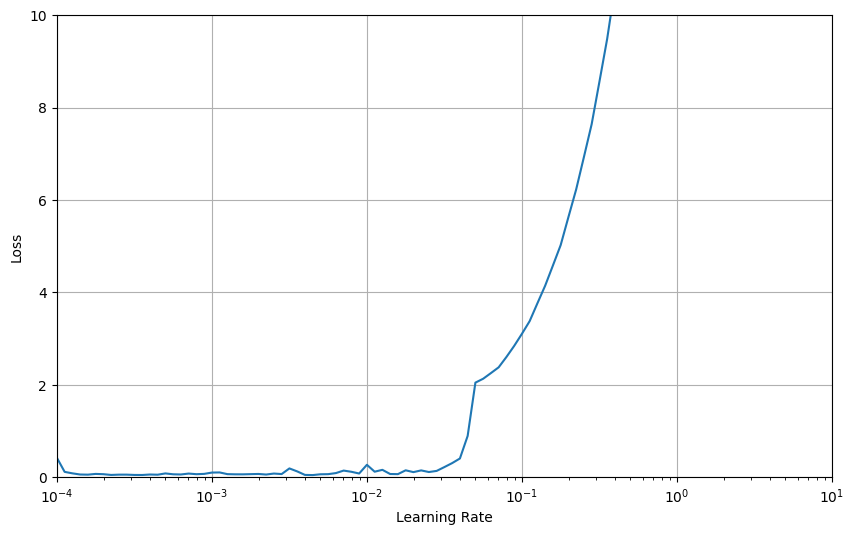

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.axis([1e-4, 10, 0, 10])
plt.grid(True)
plt.show()

In [ ]:
def create_model():
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=["mae"])
    return model

# Save an instance of the model
model = create_model()

In [ ]:
# Train it
history = model.fit(train_set, epochs=200)

Epoch 1/200
31/31 [==============================] - 6s 58ms/step - loss: 1.4141 - mae: 1.8001
Epoch 2/200
31/31 [==============================] - 2s 68ms/step - loss: 0.0569 - mae: 0.2801
Epoch 3/200
31/31 [==============================] - 3s 92ms/step - loss: 0.0551 - mae: 0.2792
Epoch 4/200
31/31 [==============================] - 2s 55ms/step - loss: 0.0734 - mae: 0.3116
Epoch 5/200
31/31 [==============================] - 2s 56ms/step - loss: 0.0497 - mae: 0.2680
Epoch 6/200
31/31 [==============================] - 2s 56ms/step - loss: 0.0613 - mae: 0.2898
Epoch 7/200
31/31 [==============================] - 2s 56ms/step - loss: 0.0654 - mae: 0.2958
Epoch 8/200
31/31 [==============================] - 2s 79ms/step - loss: 0.0520 - mae: 0.2708
Epoch 9/200
31/31 [==============================] - 3s 86ms/step - loss: 0.0725 - mae: 0.3096
Epoch 10/200
31/31 [==============================] - 2s 57ms/step - loss: 0.0468 - mae: 0.2600
Epoch 11/200
31/31 [=============================

In [ ]:
def compute_metrics(true_series, forecast):
    mse = mean_squared_error(true_series, forecast)
    mae = mean_absolute_error(true_series, forecast)
    mape = mean_absolute_percentage_error(true_series, forecast)
    accuracy = 100 - mape
    return mse, mae, mape, accuracy

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Inverse transform the predictions and the true values
rnn_forecast = scaler.inverse_transform(rnn_forecast.reshape(-1, 1)).squeeze()
series_valid = scaler.inverse_transform(series_valid.reshape(-1, 1)).squeeze()

68/68 [==============================] - 2s 16ms/step


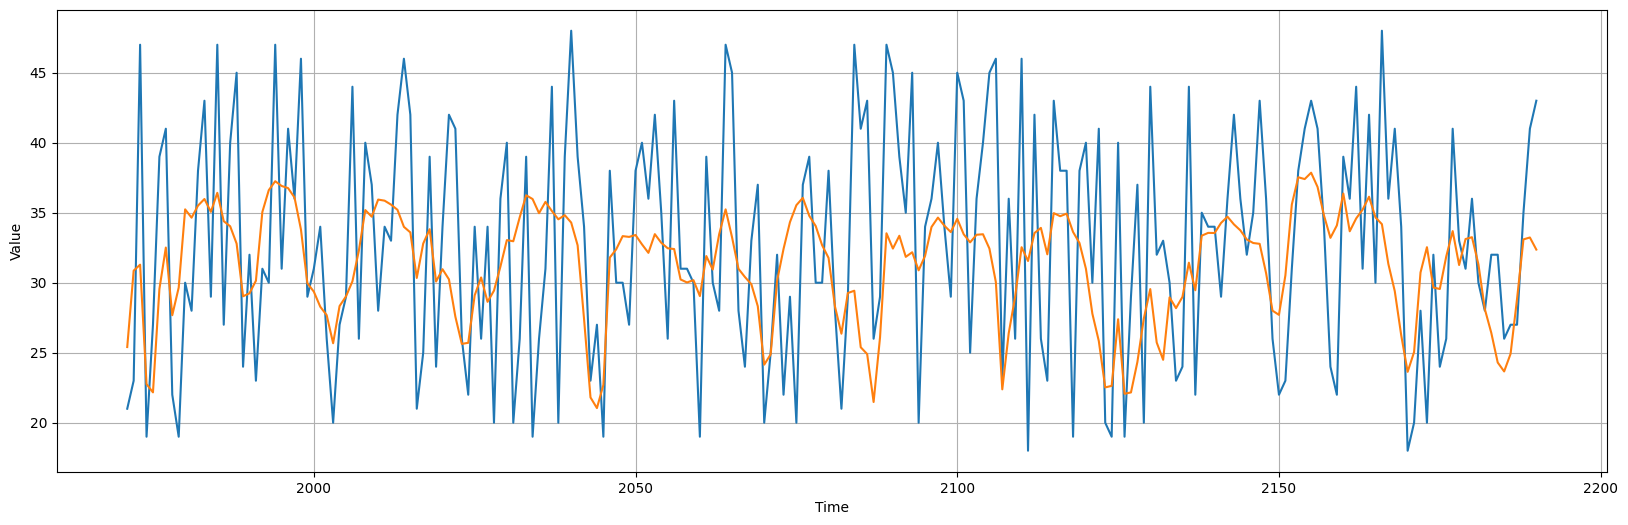

In [ ]:
# Plot the forecast
plt.figure(figsize=(20, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)
plt.show()

In [ ]:
mse, mae, mape, accuracy = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f}, mape: {mape:.2f}%, accuracy: {accuracy:.2f}% for forecast")

mse: 56.61, mae: 6.24, mape: 0.20%, accuracy: 99.80% for forecast


In [ ]:
# Save the model to a pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
# Forecasting for future days
def forecast_future(model, series, window_size, steps):
    forecast = []
    input_seq = series[-window_size:]

    for _ in range(steps):
        input_seq = input_seq.reshape((1, window_size, 1))
        pred = model.predict(input_seq)
        forecast.append(pred[0, 0])
        input_seq = np.append(input_seq[:, 1:], pred)

    return np.array(forecast)

In [ ]:
# Forecast for the next 7 days
forecast_7_days = forecast_future(model, G.SERIES, G.WINDOW_SIZE, 7)
# Forecast for the next 30 days
forecast_30_days = forecast_future(model, G.SERIES, G.WINDOW_SIZE, 30)

1/1 [==============================] - 0s 24ms/step


In [ ]:
forecast_7_days = scaler.inverse_transform(forecast_7_days.reshape(-1, 1)).squeeze()
forecast_30_days = scaler.inverse_transform(forecast_30_days.reshape(-1, 1)).squeeze()

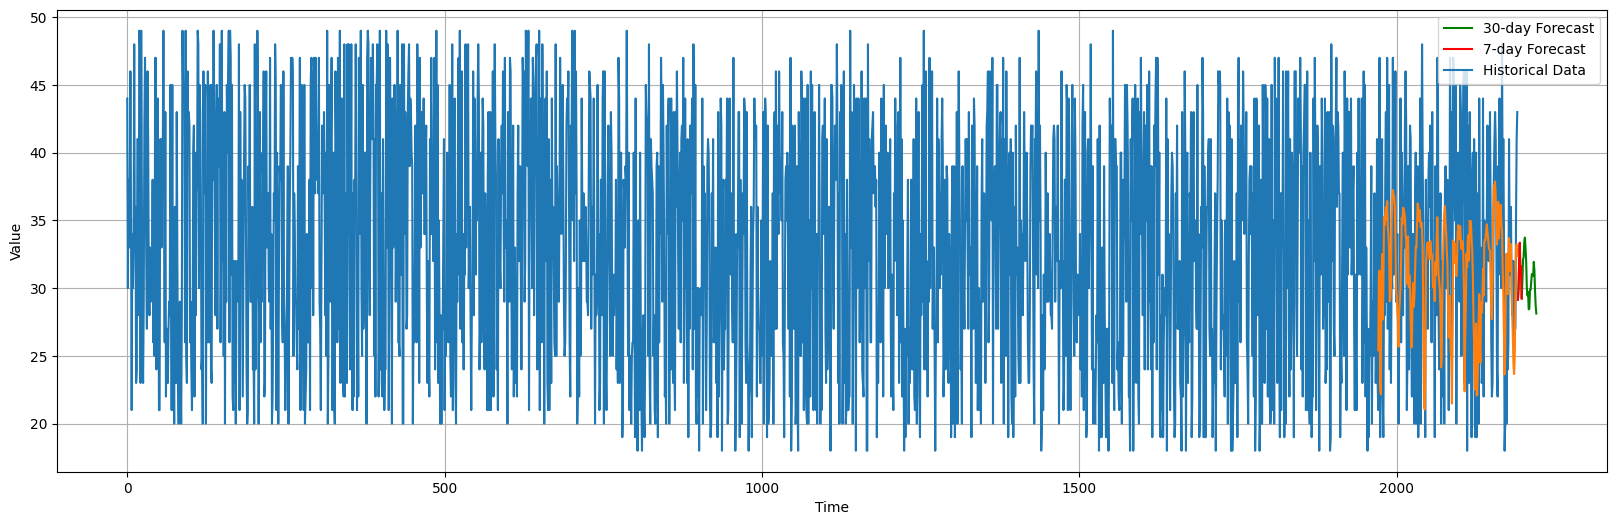

In [ ]:
# Plotting future forecasts
plt.figure(figsize=(20, 6))

plt.plot(range(len(G.SERIES), len(G.SERIES) + 30), forecast_30_days, label="30-day Forecast", color="green")
plt.plot(range(len(G.SERIES), len(G.SERIES) + 7), forecast_7_days, label="7-day Forecast", color="red")
plt.plot(range(len(G.SERIES)), scaler.inverse_transform(G.SERIES.reshape(-1, 1)), label="Historical Data")

plt.xlabel("Time")
plt.ylabel("Data Usage")
plt.legend()
plot_series(time_valid, rnn_forecast)
plt.show()

In [ ]:
# Simpan model dan scaler
model_path = 'models/model.h5'
scaler_path = 'models/scaler.pkl'
model.save(model_path)
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Model saved at {model_path}")
print(f"Scaler saved at {scaler_path}")

Model saved at models/model.h5
Scaler saved at models/scaler.pkl


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
